# Section 1: Introduction
## Research Context
To develop a computational model that simulates how the landscape of academic conferences evolves over time in 2D topical space, and to investigate the impact of online vs. offline formats on interdisciplinarity and collaboration.

- Author and institution profiling
- Topic evolution analysis
- Citation and collaboration network modeling

# Section 2: Data Sources and Extraction
## Source Overview
Two datasets were extracted from different sources:

#### HTML-based Dataset (esann_html.csv): Scraped from the ESANN conference website, this dataset includes metadata such as:

- Title
- Authors
- Abstract
- Keywords/Content Category
- PDF Link
- Year

#### PDF-based Dataset (esann_pdf.csv): Extracted from the official ESANN proceedings PDFs, this dataset includes:

- Title
- Authors
- Affiliations
- Abstract
- Filename
- Year

In [2]:
import pandas as pd

#Load both datasets
html_df = pd.read_csv("esann_html.csv")
pdf_df = pd.read_csv("esann_pdf.csv")


# Display basic information
print("HTML Dataset Shape:", html_df.shape)
print("PDF Dataset Shape:", pdf_df.shape)


# Preview the first few rows of each dataset
display(html_df.head())
display(pdf_df.head())


HTML Dataset Shape: (1553, 6)
PDF Dataset Shape: (2147, 6)


,Year,Title,Authors,Abstract,Keywords/Content Category,PDF link
0,2010,Solving Large Regression Problems using an Ens...,"Mark van Heeswijk, Yoan Miché, Erkki Oja, Amau...",This paper presents an approach that allows fo...,Machine learning techniques based on random pr...,https://www.esann.org/sites/default/files/proc...
1,2010,Mode estimation in high-dimensional spaces wit...,"Arnaud de Decker, John Aldo Lee, Damien Franco...",Data denoising can be achieved by approximatin...,Image and video analysis,https://www.esann.org/sites/default/files/proc...
2,2010,Figure-ground Segmentation using Metrics Adapt...,"Alexander Denecke, Irene Ayllon Clemente, Heik...",We present an approach for hypothesis-based im...,Image and video analysis,https://www.esann.org/sites/default/files/proc...
3,2010,An ART-type network approach for video object ...,"Rafael Luque, Enrique Domínguez, Esteban Palom...",This paper presents an ART2 (adaptive resonant...,Image and video analysis,https://www.esann.org/sites/default/files/proc...
4,2010,Computational Intelligence in biomedicine: Som...,"Paulo J.G. Lisboa, Alfredo Vellido, José D. Ma...",To be written,Computational Intelligence in Biomedicine,https://www.esann.org/sites/default/files/proc...


,Filename,Title,Authors,Affiliations,Abstract,Year
0,es2005-102.pdf,UWB radar target identification based on linea...,"Min Wang, Shuyuan Yang, Shunjun Wu",1 - Department of Electrical Engineering Natio...,"In this paper, a radical-basis-function neural...",2005
1,es2005-103.pdf,Mutual Information and Gamma Test for Input Se...,"Nima Reyhani, Jin Hao, Yongnan Ji, Amaury Lend...",1 - Helsinki University of Technology -Neural ...,"In this paper, input selection is performed us...",2005
2,es2005-104.pdf,Pruned Lazy Learning Models for Time Series Pr...,"Antti Sorjamaa, Amaury Lendasse, Michel Verley...",1 - Helsinki University of Technology -Neural ...,This paper presents two improvements of Lazy L...,2005
3,es2005-105.pdf,Clustering using a random walk based distance ...,"Luh Yen, Denis Vanvyve, Fabien Wouters, Franço...",1 - Université catholique de Louvain ISYS IAG ...,This work proposes a simple way to improve a c...,2005
4,es2005-106.pdf,A New Wrapper Method for Feature Subset Selection,"Noelia Sánchez-Maroño, Amparo Alonso-Betanzos,...",1 - Department of Computer Science LIDIA Lab U...,ANOVA decomposition is used as the basis for t...,2005


In [3]:
pdf_df = pdf_df[(pdf_df['Year'] >= 2010) & (pdf_df['Year'] <= 2025)]
html_df = html_df[(html_df['Year'] >= 2010) & (html_df['Year'] <= 2025)]

In [4]:
from rapidfuzz import process, fuzz

# Drop rows with missing titles
html_df = html_df.dropna(subset=['Title'])
pdf_df = pdf_df.dropna(subset=['Title'])

# Build the title list from html
html_titles = html_df['Title'].tolist()

# Use RapidFuzz to get the best match for each PDF title
def get_best_match(title):
    match = process.extractOne(title, html_titles, scorer=fuzz.token_sort_ratio)
    return match[0] if match else None, match[1] if match else 0

# Apply matching
matches = pdf_df['Title'].apply(get_best_match)
pdf_df['matched_title'] = matches.apply(lambda x: x[0])
pdf_df['match_score'] = matches.apply(lambda x: x[1])

# Merge datasets
merged = pdf_df.merge(html_df, left_on='matched_title', right_on='Title', suffixes=('_pdf', '_html'))

# Build final merged DataFrame
df = pd.DataFrame({
    'Title': merged['Title_pdf'],
    'Authors': merged['Authors_pdf'],
    'Affiliations': merged['Affiliations'],
    'Abstract': merged['Abstract_pdf'].combine_first(merged['Abstract_html']),
    'Keywords': merged['Keywords/Content Category'],
    'PDF Link': merged['PDF link'],
    'Year': merged['Year_pdf'],
    'Match Score': merged['match_score']
})

# Save or preview
df.to_csv("esann.csv", index=False)


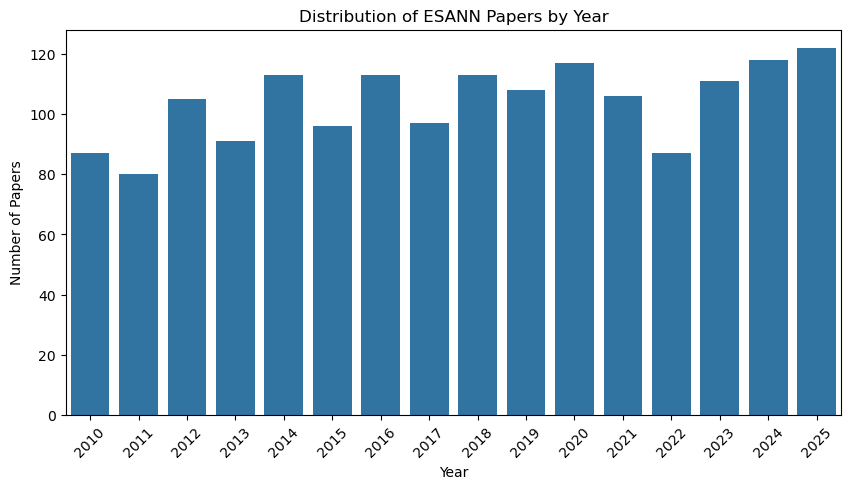

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=df, x="Year", order=sorted(df["Year"].unique()))
plt.xticks(rotation=45)
plt.title("Distribution of ESANN Papers by Year")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.show()


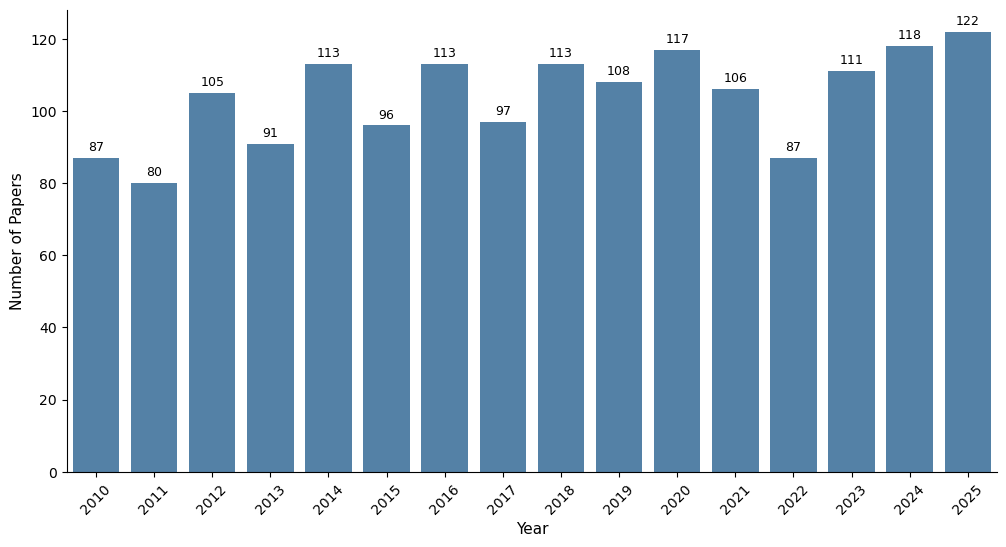

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))

sns.barplot(data=df, x="Year", y=df["Year"], estimator=lambda x: len(x),
            order=sorted(df["Year"].unique()), color="steelblue")

counts = df["Year"].value_counts().sort_index()
for i, v in enumerate(counts):
    plt.text(i, v + 2, str(v), ha="center", fontsize=9, color="black")

plt.xlabel("Year", fontsize=11)
plt.ylabel("Number of Papers", fontsize=11)
plt.xticks(rotation=45)

sns.despine()

# ⬇️ SAVE THE IMAGE HERE
plt.savefig("year_counts.png", dpi=300, bbox_inches="tight")

plt.show()


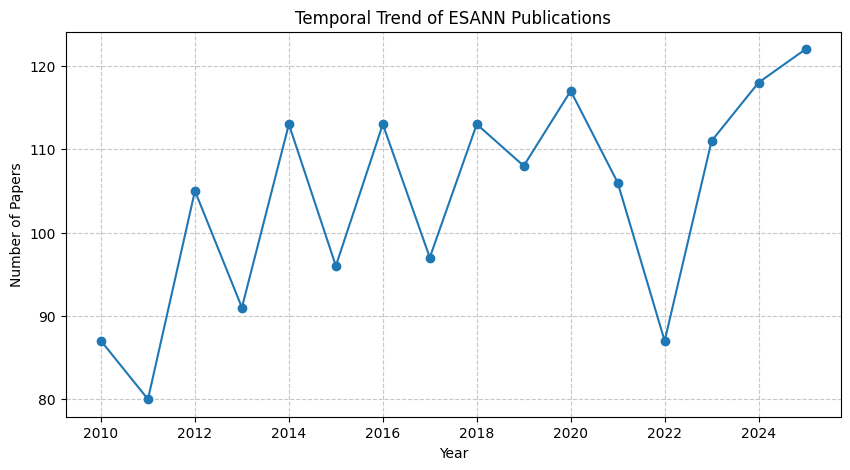

In [6]:
plt.figure(figsize=(10,5))
df_year = df["Year"].value_counts().sort_index()
plt.plot(df_year.index, df_year.values, marker="o")
plt.title("Temporal Trend of ESANN Publications")
plt.xlabel("Year")
plt.ylabel("Number of Papers")
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()


In [7]:
print("Row size:",df.index.size)
print(df.head())


Row size: 1664
                                               Title  \
0       TreeESN: a Preliminary Experimental Analysis   
1  Free-energy-based Reinforcement Learning in a ...   
2  Towards sub-quadratic learning of probability ...   
3                Heuristics Miner for Time Intervals   
4  Learning vector quantization for heterogeneous...   

                                             Authors  \
0                Claudio Gallicchio, Alessio Micheli   
1     Makoto Otsuka, Junichiro Yoshimoto, Kenji Doya   
2  François Schnitzler, Philippe Leray, Louis Weh...   
3               Andrea Burattin, Alessandro Sperduti   
4  Dietlind Zühlke, Frank-Michael Schleif, Tina G...   

                                        Affiliations  \
0  1 - Department of Computer Science University ...   
1  1 - Initial Research Project Okinawa Institute...   
2  1 - Université de Liège -Department of EECS & ...   
3  1 - Department of Pure and Applied Mathematics...   
4  1 - -RWTH Aachen -Informatio

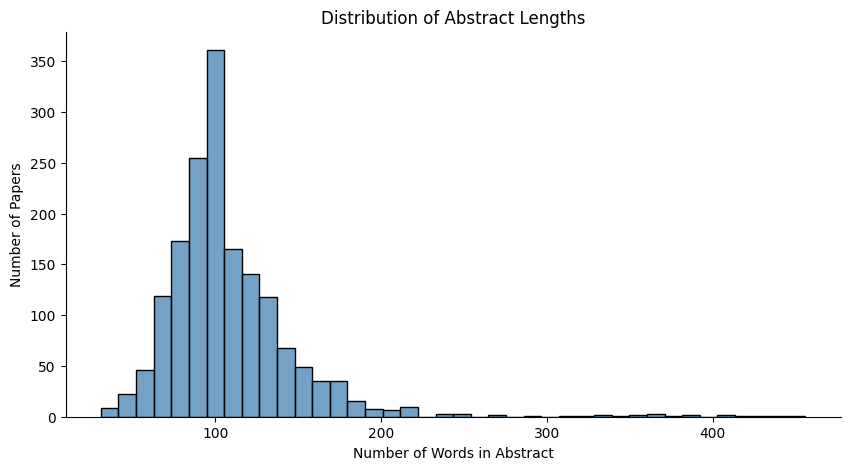

In [8]:
# Create a column for abstract length (in words)
df["abstract_length"] = df["Abstract"].apply(lambda x: len(str(x).split()))

# Plot distribution
plt.figure(figsize=(10,5))
sns.histplot(df["abstract_length"], bins=40, color="steelblue", kde=False)
plt.title("Distribution of Abstract Lengths")
plt.xlabel("Number of Words in Abstract")
plt.ylabel("Number of Papers")
sns.despine()
plt.show()


In [9]:
# Count missing values in each column
df.isnull().sum()


Title              0
Authors            2
Affiliations       9
Abstract           0
Keywords           0
PDF Link           0
Year               0
Match Score        0
abstract_length    0
dtype: int64

In [10]:
df.dtypes

Title               object
Authors             object
Affiliations        object
Abstract            object
Keywords            object
PDF Link            object
Year                 int64
Match Score        float64
abstract_length      int64
dtype: object

In [11]:
# Get a summary of the dataframe to see column types and non-null values
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1664 entries, 0 to 1663
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            1664 non-null   object 
 1   Authors          1662 non-null   object 
 2   Affiliations     1655 non-null   object 
 3   Abstract         1664 non-null   object 
 4   Keywords         1664 non-null   object 
 5   PDF Link         1664 non-null   object 
 6   Year             1664 non-null   int64  
 7   Match Score      1664 non-null   float64
 8   abstract_length  1664 non-null   int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 117.1+ KB
None


### Data Cleaning and Text Processing
#### Handle Missing Values and Combine Text Columns

In [12]:
df.drop_duplicates(inplace=True)
df.dropna(subset=['Title', 'Abstract'], inplace=True)


In [13]:
# For 'Authors' and 'Affiliations', fill missing values with 'Unknown'
# This is a common approach when the missing data cannot be reliably imputed
df['Authors'] = df['Authors'].fillna('Unknown')
df['Affiliations'] = df['Affiliations'].fillna('Unknown')

print("Missing values after filling 'Unknown':")
print(df.isnull().sum())

Missing values after filling 'Unknown':
Title              0
Authors            0
Affiliations       0
Abstract           0
Keywords           0
PDF Link           0
Year               0
Match Score        0
abstract_length    0
dtype: int64


#### Semantic Embedding Generation

- This section focuses on transforming the cleaned text into numerical vector representations (embeddings) that capture the semantic meaning of each paper.
- To import the SentenceTransformer library and load the pre-trained SPECTER model, which is specialized for scientific text.
- model = SentenceTransformer('allenai/specter') loads the SPECTER model. This model has been trained on a vast corpus of scientific papers, making it highly effective at generating semantically rich embeddings for research articles.

- Benefit: Using a pre-trained model like SPECTER saves immense computational resources compared to training one from scratch. More importantly, it provides state-of-the-art semantic representations, ensuring that papers with similar topics are represented by vectors that are close in the embedding space.

In [14]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('allenai/specter')


No sentence-transformers model found with name allenai/specter. Creating a new one with mean pooling.


In [15]:
df['Title'] = df['Title'].fillna('')
df['Abstract'] = df['Abstract'].fillna('')
df['Text_clean'] = df['Title'] + ' ' + df['Abstract']


In [16]:
# Show sample of raw vs cleaned text
df_sample = df[["Abstract", "Text_clean"]].sample(3, random_state=42)
df_sample


,Abstract,Text_clean
1448,"This paper introduces LLaMA-ES, an approach fo...",LLaMA Tunes CMA-ES This paper introduces LLaMA...
168,Several muscular degenerative diseases alter m...,Fast calibration of hand movement-based interf...
220,In randomized parallel ensembles the class lab...,On the Independence of the Individual Predicti...


In [17]:
texts = df['Title'].tolist()  # Assuming df is already loaded
specter_embeddings = model.encode(texts, show_progress_bar=True, device='cuda')

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

#### These embeddings are the core numerical representation of your textual data. They allow for quantitative analysis of semantic similarity and are the foundation for subsequent dimensionality reduction and clustering, transforming unstructured text into structured data.
